In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.extmath import safe_sparse_dot

import metrics

In [2]:
np.set_printoptions(suppress=True)
tqdm.pandas()

### Load and process data

In [3]:
def remove_padding(name):
    return name[1:-1]

def add_padding(name):
    return '<' +  name + '>'

In [4]:
df = pd.read_csv('data/records25k_data.tsv', sep='\t', header=None)
df.columns = ['name1', 'name2', 'co_occurrence', 'count1', 'count2']
df.dropna(inplace=True)

In [5]:
# Add padding 
df['name1'] = df['name1'].map(add_padding)
df['name2'] = df['name2'].map(add_padding)

In [6]:
df_name_matches = df.groupby('name1')['name2'].agg(list).reset_index()
all_candidates = np.array(list(set(df['name2'].tolist())))
relevants = df_name_matches['name2'].tolist()

### Model

In [7]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), analyzer='char_wb', min_df=10)

In [8]:
X = vectorizer.fit_transform(all_candidates)

#### Similarity Function

In [9]:
def get_similars(name, k=10, demo_mode=False):
    if demo_mode:
        name = add_padding(name)
    x = vectorizer.transform([name]).toarray()
    scores = safe_sparse_dot(X, x.T).flatten()
    sorted_scores_idx = np.argsort(scores)[::-1][:k]
    candidates = all_candidates[sorted_scores_idx]
    if demo_mode:
        candidates = [remove_padding(candidate) for candidate in candidates]
    candidates_scores = scores[sorted_scores_idx]
    
    return list(zip(candidates, candidates_scores))

#### Demo

In [10]:
get_similars('schumacher', 10, True)

[('schumacker', 0.813049306612787),
 ('schuman', 0.7508859846317513),
 ('schumann', 0.7043014953156552),
 ('schumaker', 0.6964039007889642),
 ('schacher', 0.6624217118690013),
 ('schum', 0.640295210773405),
 ('scheuman', 0.5648330047009849),
 ('hamacher', 0.5521985335793914),
 ('amacher', 0.5464928177103441),
 ('stelmacher', 0.5398458711849166)]

### Generate candidates for all names

In [11]:
k = 100 # Number of candidates
name_candidates = df_name_matches['name1'].progress_apply(get_similars, k=k)
candidates = np.array(name_candidates.tolist())[:,:, 0]

100%|██████████| 23587/23587 [01:14<00:00, 318.28it/s]


### Evaluation

In [12]:
def precision_recall(relevants, candidates, N):
    precisions = []
    recalls = []
    for i in range(N):
        precisions.append(np.mean([metrics.precision_k(a, c, i + 1) for a, c in zip(relevants, candidates)]))
        recalls.append(np.mean([metrics.recall_k(a, c, i + 1) for a, c in zip(relevants, candidates)]))
    return precisions, recalls

### mAP@1

In [13]:
metrics.mean_avg_precision_k(relevants, candidates, 1)

0.49217789460295924

### mAP@3

In [14]:
metrics.mean_avg_precision_k(relevants, candidates, 3)

0.407076873795829

### Precision-Recall Curve

In [15]:
# Number of rank cutoffs to test i.e precision_{i}, recall_{i} for i in (1, ..., N)
N = 100
precisions, recalls = precision_recall(relevants, candidates, N)

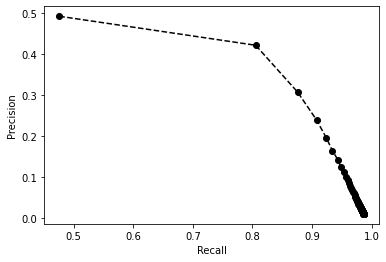

In [16]:
plt.plot(recalls, precisions, 'ko--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()